In [101]:
import random
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from helper import displayEpipolarF, calc_epi_error, toHomogenous
from q2_1_eightpoint import eightpoint
from q2_2_sevenpoint import sevenpoint
from q3_2_triangulate import findM2
from q4_1_epipolar_correspondence import epipolarCorrespondence

import scipy

# Insert your package here


# Helper functions for this assignment. DO NOT MODIFY!!!
"""
Helper functions.

Written by Chen Kong, 2018.
Modified by Zhengyi (Zen) Luo, 2021
"""
def plot_3D_dual(P_before, P_after):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Blue: before; red: after")
    ax.scatter(P_before[:,0], P_before[:,1], P_before[:,2], c = 'blue')
    ax.scatter(P_after[:,0], P_after[:,1], P_after[:,2], c='red')
    plt.draw()
    plt.show()
    # while True:
    #     x, y = plt.ginput(1, mouse_stop=2)[0]
    #     plt.draw()


'''
Q5.1: RANSAC method.
    Input:  pts1, Nx2 Matrix
            pts2, Nx2 Matrix
            M, a scaler parameter
            nIters, Number of iterations of the Ransac
            tol, tolerence for inliers
    Output: F, the fundamental matrix
            inliers, Nx1 bool vector set to true for inliers

    Hints:
    (1) You can use the calc_epi_error from q1 with threshold to calcualte inliers. Tune the threshold based on 
        the results/expected number of inliners. You can also define your own metric. 
    (2) Use the seven point alogrithm to estimate the fundamental matrix as done in q1
    (3) Choose the resulting F that has the most number of inliers
    (4) You can increase the nIters to bigger/smaller values
 
'''
def ransacF(pts1, pts2, M, im1, im2, nIters=500, tol=18):
    """
    Every iteration we init a Homography matrix using 4 corresponding
    points and calculate number of inliers. Finally use the Homography
    matrix which had max number of inliers (and these inliers as well)
    to find the final Homography matrix
    Args:
        pts1: location of matched points in image1
        pts2: location of matched points in image2
        opts: user inputs used for distance tolerance in ransac

    Returns:
        bestH2to1     : The homography matrix with max number of inliers
        inlier_points : Final list of inliers found for best RANSAC iteration
    """
    max_iters = nIters # the number of iterations to run RANSAC for
    inlier_tol = tol # the tolerance value for considering a point to be an inlier
    locs1 = pts1
    locs2 = pts2

    # define size of both locs1 and locs2
    num_rows = locs1.shape[0]

    # define a container for keeping track of inlier counts
    final_inlier_count = 0
    final_distance_error = 100000000

    #? Create a boolean vector of length N where 1 = inlier and 0 = outlier
    print("Computing RANSAC")
    for i in range(max_iters):
        test_locs1 = deepcopy(locs1)
        test_locs2 = deepcopy(locs2)
        # chose a random sample of 4 points to find H
        rand_index = []
        
        rand_index = random.sample(range(int(locs1.shape[0])), k=8)
        
        rand_points_1 = []
        rand_points_2 = []
        
        for j in rand_index:
            rand_points_1.append(locs1[j,:])
            rand_points_2.append(locs2[j,:])
        
        test_locs1 = np.delete(test_locs1, rand_index, axis=0)
        test_locs2 = np.delete(test_locs2, rand_index, axis=0)
            
        correspondence_points_1 = np.vstack(rand_points_1)
        correspondence_points_2 = np.vstack(rand_points_2)

        ref_F = eightpoint(correspondence_points_1, correspondence_points_2, M)
        inliers, inlier_count, distance_error, error_state = compute_inliers(ref_F, 
                                                                            test_locs1,
                                                                            test_locs2, 
                                                                            inlier_tol,
                                                                            im1,
                                                                            im2)

        if error_state == 1:
            continue

        if (inlier_count > final_inlier_count):
            final_inlier_count = inlier_count
            final_inliers = inliers
            final_corresp_points_1 = correspondence_points_1
            final_corresp_points_2 = correspondence_points_2
            final_distance_error = distance_error
            final_test_locs1 = test_locs1
            final_test_locs2 = test_locs2
        
    if final_distance_error != 100000000:
        # print("original point count is", locs1.shape[0])
        print("final inlier count is", final_inlier_count)
        print("final inlier's cumulative distance error is", final_distance_error)

        delete_indexes = np.where(final_inliers==0)
        final_locs_1 = np.delete(final_test_locs1, delete_indexes, axis=0)
        final_locs_2 = np.delete(final_test_locs2, delete_indexes, axis=0)

        final_locs_1 = np.vstack((final_locs_1, final_corresp_points_1))
        final_locs_2 = np.vstack((final_locs_2, final_corresp_points_2))

        bestH2to1 = eightpoint(final_locs_1, final_locs_2, M)
        return bestH2to1, [final_locs_1, final_locs_2]
    
    else:
        print("SOMETHING WRONG")
        bestH2to1 = eightpoint(correspondence_points_1, correspondence_points_2, M)
        return bestH2to1, 0
    

def compute_inliers(f, x1, x2, tol, im1, im2):
    """
    Compute the number of inliers for a given
    Fundamental matrix
    Args:
        h  : Fundamental matrix
        x1 : matched points in image 1 (Nx2)
        x2 : matched points in image 2 (Nx2)
        tol: tolerance value to check for inliers

    Returns:
        inliers         : indexes of x1 or x2 which are inliers
        inlier_count    : number of total inliers
        dist_error_sum  : Cumulative sum of errors in reprojection error calc
        flag            : flag to indicate if H was invertible or not
    """

    pts1_homogenous, pts2_homogenous = toHomogenous(x1), toHomogenous(x2)
    dist_error = calc_epi_error(pts1_homogenous, pts2_homogenous, f)
    dist_error= np.expand_dims(dist_error, axis=1)
    
    print("dist error is", np.sum(dist_error))
    inliers = np.where((dist_error < tol), 1, 0)
    inlier_count = np.count_nonzero(inliers == 1)
    print("inlier count is", inlier_count)
    
    return inliers, inlier_count, np.sum(dist_error), 0


'''
Q5.2: Rodrigues formula.
    Input:  r, a 3x1 vector
    Output: R, a 3x3 rotation matrix
'''
def rodrigues(r):
    """
    Compute the Rotation matrix from given exponential form
    Refer: https://courses.cs.duke.edu//fall13/compsci527/notes/rodrigues.pdf

    Args:
        r : rotation axis
    
    Returns:
        R : rotation matrix
    """
    thetha = np.linalg.norm(r)
    if thetha == 0:
        R = np.eye(3,3)
    else:
        u = r/thetha
        u = np.reshape(u, newshape=(3,1))
        u_skew = np.array([[0, -u[2,0], u[1,0]], 
                           [u[2,0], 0, -u[0,0]],
                           [-u[1,0], u[0,0], 0]])

        R = np.cos(thetha)*np.eye(3,3) + ((1 - np.cos(thetha))*(u @ u.T)) + np.sin(thetha)*u_skew
    
    return R


'''
Q5.2: Inverse Rodrigues formula.
    Input:  R, a rotation matrix
    Output: r, a 3x1 vector
'''
def invRodrigues(R):
    """
    Calulate the rotation axis vector given Rotation matrix

    Args:
        R : rotation matrix

    Returns:
        r : rotation axis
    """
    A = (R - R.T)/2
    rho = np.array([[A[2,1]],[A[0,2]],[A[1,0]]])
    s = np.linalg.norm(rho)
    c = (R[0,0] + R[1,1] + R[2,2] - 1)/2
    
    if s == 0 and c == 1:
        r = np.array([0,0,0])
    
    else:
        u = rho/s
        thetha = np.arctan2(s,c)
        r = thetha*u
    
    return r[:,0]


'''
Q5.3: Rodrigues residual.
    Input:  K1, the intrinsics of camera 1
            M1, the extrinsics of camera 1
            p1, the 2D coordinates of points in image 1
            K2, the intrinsics of camera 2
            p2, the 2D coordinates of points in image 2
            x, the flattened concatenation of P, r2, and t2 
               (we get M2(r2 and t2) and P using findM2 function)
    Output: residuals, 4N x 1 vector, the difference between original and estimated projections
'''
def rodriguesResidual(x, K1, M1, p1, K2, p2):
    """
    Generate the reprojection error, we call it residual_error here
    Args:
        K1 (3x3)     : Intrinsic matrix of camera 1
        M1 (3x4)     : Extrinsic matrix of camera 1
        p1 (Nx2)     : keypoints in camera1's image (2D)
        K2 (3x3)     : Intrinsic matrix of camera 2
        p2 (Nx2)     : keypoints in camera2's image
        x  (3N +3 +3): the flattened concatenation of P, r2, and t2 
                       (we get M2(r2 and t2) and P using findM2 function)
    """
    
    '''
    x has P.flatten() viz Nx3 flattened as 3N
    the 3N gets added with 3 numbers to represent rotation in rodrigues form
    the 3N + 3 again gets appended with 3 numbers which represent translation in 3D
    therefore the final x will be of shape 3N + 3 + 3 = 3N + 6
    '''
    
    # decompose x
    P = x[0:-6]
    P_shape_req = int(P.shape[0]/3)
    P = np.reshape(P, newshape=(P_shape_req,3))
    
    r2 = x[-6:-3]
    # reshape to 3x1 to feed to inverse rodrigues
    r2 = r2.reshape(3,1)

    # reshape translation matrix to combine in transformation matrix
    t2 = x[-3:].reshape(3,1)

    # compose the C2 matrix
    R2 = rodrigues(r2)
    M2 = np.hstack((R2,t2))
    C2 = K2 @ M2

    # compose the C1 matrix
    C1 = K1 @ M1

    # homogenize P to contain a 1 in the end (P = Nx3 vector)
    P_homogenous = np.append(P, np.ones((P.shape[0],1)), axis=1)
    
    # Find the projection of P1 onto image 1 (vectorize)
    # Transpose P_homogenous to make it a 4xN vector and left mulitply with C1
    #  3xN =  3x4 @ 4XN
    p1_hat = (C1 @ P_homogenous.T)
    # normalize and transpose to get back to format of p1
    p1_hat = ((p1_hat/p1_hat[2,:])[0:2,:]).T

    # Repeat for C2
    p2_hat = (C2 @ P_homogenous.T)
    # normalize and transpose to get back to format of p2
    p2_hat = ((p2_hat/p2_hat[2,:])[0:2,:]).T

    residuals = np.concatenate([(p1-p1_hat).reshape([-1]),(p2-p2_hat).reshape([-1])])
    residuals = np.sum(residuals)

    return residuals

In [105]:
'''
Q5.3 Bundle adjustment.
    Input:  K1, the intrinsics of camera 1
            M1, the extrinsics of camera 1
            p1, the 2D coordinates of points in image 1
            K2,  the intrinsics of camera 2
            M2_init, the initial extrinsics of camera 1 (get this from findM2)
            p2, the 2D coordinates of points in image 2
            P_init, the initial 3D coordinates of points (get this also from findM2)
    Output: M2, the optimized extrinsics of camera 1
            P2, the optimized 3D coordinates of points
            o1, the starting objective function value with the initial input
            o2, the ending objective function value after bundle adjustment

    Hints:
    (1) Use the scipy.optimize.minimize function to minimize the objective function, rodriguesResidual. 
        You can try different (method='..') in scipy.optimize.minimize for best results. 
'''
def bundleAdjustment(K1, M1, p1, K2, M2_init, p2, P_init):
    
    # given M2_init decompose it into R and t
    R2 = M2_init[:,0:3]
    t2 = M2_init[:,3]
    r2 = invRodrigues(R2)

    x_start = P_init.flatten()
    x_start = np.append(x_start, np.append(r2.flatten(), t2))

    obj_start = rodriguesResidual(x_start, K1, M1, p1, K2, p2)
    print("x_start shape is", x_start.shape)

    # optimization step
    from scipy.optimize import minimize
    x_optimized_obj = minimize(rodriguesResidual, x_start, args=(K1, M1, p1, K2, p2), method='Nelder-Mead')
    print("x_end shape is", x_optimized_obj.x.shape)
    x_optimized = x_optimized_obj.x

    obj_end = rodriguesResidual(x_optimized, K1, M1, p1, K2, p2)

    # recompute the M2 and P
    # decompose x
    P_final = x_optimized[0:-6]
    P_shape_req = int(P_final.shape[0]/3)
    P_final = np.reshape(P_final, newshape=(P_shape_req,3))
    
    r2_final = x_optimized[-6:-3]
    # reshape to 3x1 to feed to inverse rodrigues
    r2_final = r2_final.reshape(3,1)

    # reshape translation matrix to combine in transformation matrix
    t2_final = x_optimized[-3:].reshape(3,1)

    # compose the C2 matrix
    R2_final = rodrigues(r2_final)
    M2_final = np.hstack((R2_final, t2_final))
    
    return M2_final, P_final, obj_start, obj_end

In [91]:
# MAIN FUNCTION
np.random.seed(1) #Added for testing, can be commented out

some_corresp_noisy = np.load('data/some_corresp_noisy.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
noisy_pts1, noisy_pts2 = some_corresp_noisy['pts1'], some_corresp_noisy['pts2']
im1 = plt.imread('data/im1.png')
im2 = plt.imread('data/im2.png')

templeCoords = np.load('data/templeCoords.npz')
temple_pts1 = np.hstack([templeCoords["x1"], templeCoords["y1"]])

#? getting the F matrix from noisy correspondences
M = np.max([*im1.shape, *im2.shape])

F, inliers = ransacF(noisy_pts1, noisy_pts2, M, im1, im2)
inlier_pts1, inlier_pts2 = inliers[0], inliers[1]

print("shape of noisy_pts1 is", noisy_pts1.shape)
print("shape of inlier_pts1 is", inlier_pts1.shape)

F_naieve = eightpoint(noisy_pts1, noisy_pts2, M)

# use displayEpipolarF to compare how ransac_F and naieve_F behave
# displayEpipolarF(im1, im2, F)
# displayEpipolarF(im1, im2, F_naieve)

# Simple Tests to verify your implementation:
assert(F.shape == (3, 3))
assert(F[2, 2] == 1)
assert(np.linalg.matrix_rank(F) == 2)

Computing RANSAC
Optimization terminated successfully.
         Current function value: 0.000167
         Iterations: 58
         Function evaluations: 6163
dist error is 2927557.0263644247
inlier count is 21
Optimization terminated successfully.
         Current function value: 0.000444
         Iterations: 11
         Function evaluations: 1236
dist error is 2336838.6009178394
inlier count is 54
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 57
         Function evaluations: 7145
dist error is 2285450.3597263866
inlier count is 46
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 1947
dist error is 1379309.5800730535
inlier count is 20
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 1028
dist error is 1804064.6324217739
inlier count is 90
Optimization terminated 

rank of E is 2
error in this iteration is 304.01865992917976
error in this iteration is 304.01865992917976
error in this iteration is 304.0187303788618
satisfies the error criteria
error in this iteration is 304.0187303788618
min err is 304.0187303788618
M2 shape is [[ 0.99943003  0.03304472  0.00690412 -0.0272398 ]
 [-0.03370186  0.96485402  0.26061638 -1.        ]
 [ 0.00195053 -0.26070052  0.96541775  0.06164326]]
x_start shape is (333,)


/tmp/ipykernel_59084/1304916421.py:301: RuntimeWarning: divide by zero encountered in divide
  p2_hat = ((p2_hat/p2_hat[2,:])[0:2,:]).T
/tmp/ipykernel_59084/1304916421.py:301: RuntimeWarning: invalid value encountered in divide
  p2_hat = ((p2_hat/p2_hat[2,:])[0:2,:]).T
/home/sush/.local/lib/python3.8/site-packages/scipy/optimize/_optimize.py:790: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


x_end shape is (333,)


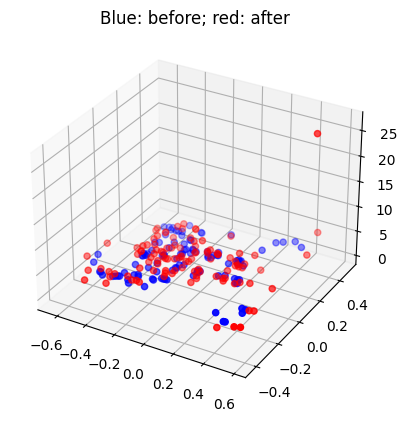

In [106]:
# Simple Tests to verify your implementation:
from scipy.spatial.transform import Rotation as sRot
rotVec = sRot.random()
mat = rodrigues(rotVec.as_rotvec())
assert(np.linalg.norm(rotVec.as_rotvec() - invRodrigues(mat)) < 1e-3)
assert(np.linalg.norm(rotVec.as_matrix() - mat) < 1e-3)

#? Getting the initial guess for M2 and P
# Assuming the rotation and translation of camera1 is zero
M1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
M2_init, C2, P_init, M1, C1 = findM2(F, inlier_pts1, inlier_pts2, intrinsics)
print("M2 shape is", M2_init)

# Optimize the M2
M2_final, P_final, start_obj, end_obj = bundleAdjustment(
                                                         K1, 
                                                         M1, 
                                                         inlier_pts1, 
                                                         K2, 
                                                         M2_init, 
                                                         inlier_pts2, 
                                                         P_init
                                                        )

# compare the old M2 to optimized M2
plot_3D_dual(P_init, P_final)